![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 15 - Forward and Backward</center>
### <center> Back-propagation - Solution</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_Backpropagation/Backpropagation%20-%20Solution.ipynb)

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(4)

###  Constructing the different layers:
Each layer should have a `Forward` method and a `Backward` method

#### Affine (linear) layer
Forward:
$$\boldsymbol{z}=\boldsymbol{W}\boldsymbol{x}+\boldsymbol{b}$$

Gradients:
$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{b}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{b}}L=\nabla_{\boldsymbol{z}}L}$$
  

$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{x}}L,\boldsymbol{W}\boldsymbol{h}\right\rangle =\left\langle \boldsymbol{W}^{T}\nabla_{\boldsymbol{x}}L,\boldsymbol{h}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{x}}L=\boldsymbol{W}^{T}\nabla_{\boldsymbol{z}}L}$$

$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{W}}\boldsymbol{z}\left[\boldsymbol{H}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{x}}L,\boldsymbol{H}\boldsymbol{x}\right\rangle =\left\langle \nabla_{\boldsymbol{W}}L\boldsymbol{x}^{T},\boldsymbol{H}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{W}}L=\nabla_{\boldsymbol{z}}L\boldsymbol{x}^{T}}$$

In [2]:
class LinearLayer:
    def __init__(self, dIn, dOut):
        mW = np.random.randn(dOut, dIn) / dIn
        vB = np.zeros(dOut)
        
        self.dParams = {'mW' : mW, 'vB': vB}
        self.dGrads  = {}
        
    def Forward(self, mX):
        mW      = self.dParams['mW']
        vB      = self.dParams['vB']
        self.mX = mX                   #-- store for Backward
        mZ      = mW @ mX + vB[:,None]
        
        return mZ
    
    def Backward(self, mDz):
        mW  = self.dParams['mW']
        
        vDb = mDz.sum(axis=1)
        mDw = mDz @ self.mX.T
        mDx = mW.T @ mDz
        
        self.dGrads['vB'] = vDb
        self.dGrads['mW'] = mDw
                
        return mDx

#### ReLU Layer
Forward:
$$\boldsymbol{z}=\text{ReLU}\left(\boldsymbol{x}\right)=\max\left\{ \boldsymbol{x},0\right\} $$

Gradient:
$$\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\boldsymbol{h}\right\rangle =\left\langle \text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle $$
$$\implies\boxed{\nabla_{\boldsymbol{x}}L=\text{diag}\left(\mathbb{I}_{\boldsymbol{x}>0}\right)\nabla_{\boldsymbol{z}}L}$$

In [3]:
class ReLULayer:
    def __init__(self):
        self.dGrads = {}
    
    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0)
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(float)
        
        mDx   = mDz * mMask
                
        return mDx

#### It is efficient to combine the Softmax layer with the cross entropy loss

### Generic model:
The model is simply a list of layers

In [4]:
class Model:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        
    def Forward(self, mX):
        for oLayer in self.lLayers:
            mX = oLayer.Forward(mX)
        return mX
    
    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

###  Loss function (Cross entropy + Softmax)
$$\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)$$
where
$$\hat{\boldsymbol{y}}=\text{softmax}\left(\boldsymbol{z}\right)=\frac{\exp\left(\boldsymbol{z}\right)}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}$$

Gradient:  
First, we note that
\begin{align*}
\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right) & =-\boldsymbol{y}_{i}^{T}\log\left(\hat{\boldsymbol{y}}_{i}\right)\\
 & =-\boldsymbol{y}_{i}^{T}\log\left(\frac{\exp\left(\boldsymbol{z}\right)}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}\right)\\
 & =-\boldsymbol{y}_{i}^{T}\left(\log\left(\exp\left(\boldsymbol{z}\right)\right)-\boldsymbol{1}\log\left(\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\right)\right)\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{z}+\log\left(\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\right)
\end{align*}

Hence:   
\begin{align*}
\nabla_{\boldsymbol{z}}\ell\left(\boldsymbol{z}\right)\left[\boldsymbol{h}\right] & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\nabla_{\boldsymbol{z}}\log\left(\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\right)\left[\boldsymbol{h}\right]\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\frac{1}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}\nabla\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)\left[\boldsymbol{h}\right]\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\frac{1}{\boldsymbol{1}^{T}\exp\left(\boldsymbol{z}\right)}\exp\left(\boldsymbol{z}^{T}\right)\boldsymbol{h}\\
 & =-\boldsymbol{y}_{i}^{T}\boldsymbol{h}+\hat{\boldsymbol{y}}_{i}\boldsymbol{h}\\
 & =\left\langle \hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i},\boldsymbol{h}\right\rangle 
\end{align*}

$$\implies\boxed{\nabla_{\boldsymbol{z}}\ell=\hat{\boldsymbol{y}}_{i}-\boldsymbol{y}_{i}}$$

#### Overall loss:
$$L=\frac{1}{N}\sum_{i=1}^{N}\ell_{i}=\frac{1}{N}\sum_{i=1}^{N}\ell\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)$$

In [5]:
def CrossEntropyLoss(vY, mZ):
    '''
    Returns both the loss and the gradient w.r.t the input (mZ)
    '''
    mHatY  = np.exp(mZ)
    mHatY /= np.sum(mHatY, axis=0)
    N      = len(vY)
    loss   = -np.log(mHatY[vY,range(N)]).mean()
    
    mDz               = mHatY
    mDz[vY,range(N)] -= 1
    mDz              /= N
    
    return loss, mDz

In [6]:
def TrainModel(oModel, mX, vY, numIter, learningRate):
    fig   = plt.figure(figsize=(8, 4))
    vLoss = np.full(numIter, np.nan)

    for ii in range(numIter):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]

        #-- Display:
        vLoss[ii] = loss
        print('\rIteration: ', ii, '. loss = ', loss, end='')
        plt.cla()
        plt.plot(vLoss)
        plt.xlabel('Iterations')
        plt.ylabel('Training loss')
        fig.canvas.draw()
        plt.pause(1e-20)

### Exercise
* Implement the Leaky-ReLU layer.
* Use the California housing dataset `fetch_california_housing`.
* Replace the cross-entropy loss with the MSE loss, that is:
$$\ell_{i}=\left(\hat{y}_{i}-y_{i}\right)^{2}$$
where $y_{i}\in\mathbb{R}$ is the true value and $\hat{y}_{i}\in\mathbb{R}$
is the model output.
* Try to get the best MSE\R2 score you can.
* You should test different models (layers\activations) and hyper-parameters.
* Make sure your results are better than linear regression.

In [7]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= np.mean(mX, axis=0)
mX     /= np.std(mX, axis=0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [8]:
np.std(vY)

1.1539282040412253

In [9]:
from sklearn.model_selection import train_test_split

Ntrain  = 15000
Ntest   = 5640
vIdx    = np.random.choice(Ntrain + Ntest, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((15000, 8), (15000,), (5640, 8), (5640,))

In [10]:
def MSE(vY, vHatY):
    
    loss = np.linalg.norm(vHatY - vY)**2 / len(vY)
    vDz  = 2 * (vHatY - vY)
    
    return loss, vDz

In [11]:
def TrainModel(oModel, mX, vY, numIter, learningRate):
    fig   = plt.figure(figsize=(8, 4))
    vLoss = np.full(numIter, np.nan)

    for ii in range(numIter):

        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = MSE(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (vanilla gradient descnet)
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]

        #-- Display:
        vLoss[ii] = loss
        print('Iteration: ', ii, '. loss = ', loss, '\r', end='')
        plt.cla()
        plt.plot(vLoss)
        plt.xlabel('Iterations')
        plt.ylabel('Training loss')
        fig.canvas.draw()
        plt.pause(1e-20)

In [12]:
class LeakyReLULayer:
    def __init__(self, slope=0.01):
        self.dGrads = {}
        self.slope  = slope
    
    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0) + np.minimum(self.slope * mX, 0)
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(float) + self.slope * (mX < 0).astype(float)
        
        mDx   = mDz * mMask
                
        return mDx

<IPython.core.display.Javascript object>


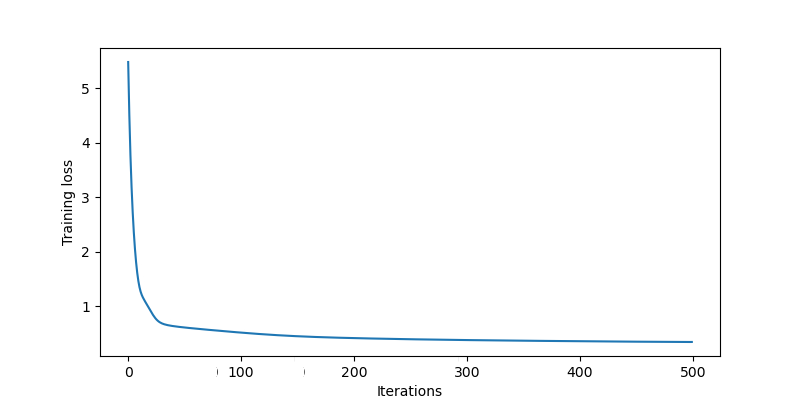

In [13]:
%matplotlib notebook

oModel = Model([
    LinearLayer(8, 200),
    ReLULayer(),
    LinearLayer(200, 250),
    ReLULayer(),
    LinearLayer(250, 1),
])

TrainModel(oModel, mTrainX.T, vTrainY, 500, 4e-6)

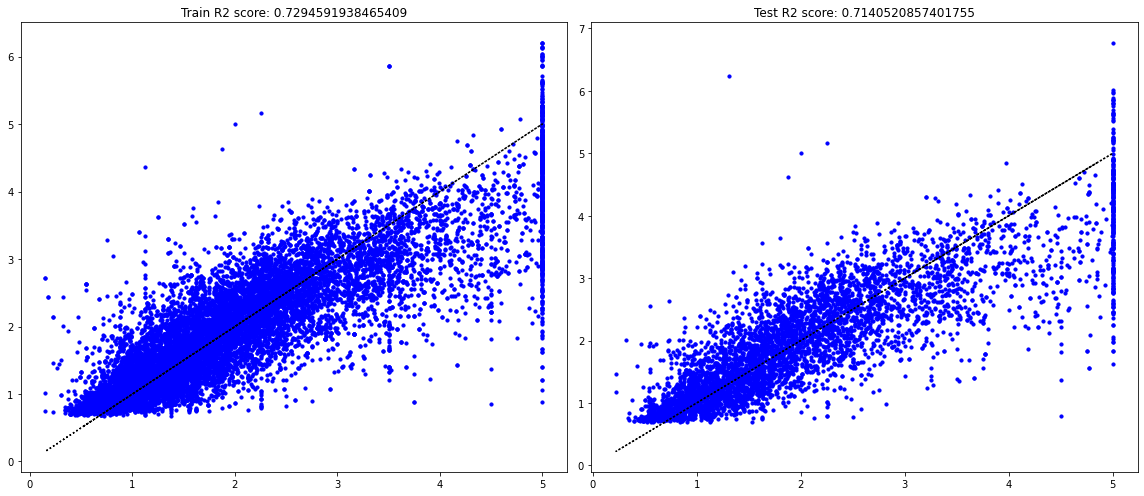

In [14]:
%matplotlib inline

from sklearn.metrics import r2_score

#-- Apply model to data:
vHatTrainY = oModel.Forward(mTrainX.T).squeeze()
vHatTestY  = oModel.Forward(mTestX.T).squeeze()

_, ax = plt.subplots(1, 2, figsize=(16,7))

ax[0].scatter(vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter(vTestY,  vHatTestY,  s=10, c='b', edgecolor=None)
ax[0].plot(vTrainY,    vTrainY, ':k')
ax[1].plot(vTestY,     vTestY, ':k')
ax[0].set_title('Train R2 score: ' + str(r2_score(vTrainY, vHatTrainY)))
ax[1].set_title('Test R2 score: '  + str(r2_score(vTestY,  vHatTestY)))
plt.tight_layout()
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression

oReg = LinearRegression().fit(mX, vY)
oReg.score(mX, vY)

0.6111672517241353